# Лабораторная работа №2. Оптимальные портфели инвестиций. 

Выполнили студенты 19ПМИ-2: Созинов Кирилл, Матвеев Андрей, Иванов Даниил.



In [3]:
from mpl_toolkits.mplot3d.axes3d import math
%pip install yfinance > /dev/null
import scipy.stats
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import time
import requests
import io
import os
import math
from scipy.stats import shapiro, normaltest, anderson
import seaborn as sns
from tqdm import tqdm_notebook
from scipy import optimize

���⥬� �� 㤠���� ���� 㪠����� ����.


Note: you may need to restart the kernel to use updated packages.


## Загрузка данных

In [5]:
log_returns = pd.read_csv('data/log_returns.csv')

In [104]:
stats_all = pd.DataFrame(columns = ['Expected returns', 'Standard deviation'])
stats_all['Expected returns'] = log_returns.mean()
stats_all['Standard deviation'] = log_returns.std()
stats_all

C:\Users\ciril\AppData\Local\Temp/ipykernel_996/2862928089.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_all['Expected returns'] = log_returns.mean()
C:\Users\ciril\AppData\Local\Temp/ipykernel_996/2862928089.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_all['Standard deviation'] = log_returns.std()


,Expected returns,Standard deviation
3IN,0.000758,0.008050
888,-0.001853,0.021774
AAIF,-0.000280,0.010566
AAL,0.000566,0.022364
AAS,-0.000114,0.009960
...,...,...
WWH,-0.000227,0.011628
XAR,-0.003489,0.038060
XPP,-0.001775,0.018614
XPS,-0.000405,0.019001


## Задание 1. Efficient frontier.

1. Efficient frontier. Выбрать на рынке набор из 50 акций.  Объясните ваш выбор. Построить 
эффективный фронт портфелей инвестиций без ограничений на короткие позиции и  эффективный 
фронт с запретом коротких позиций. Сравнить эффективные фронты и сделать выводы.  При 
построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на 
соответствующем эффективном фронте. Рассмотреть портфель  с равными долями вложения 
капитала и оценить, как  далек этот портфель от эффективного фронта. Тот же вопрос для индекса 
рынка.

Для определения наиболее предпочтительных акций используем **коэффициент Шарпа (sharp ratio)**

Скачиваем данные для нахождения мат. ожидания безрисковой акции (годовая гос. облигация)

In [7]:
bonds = pd.read_csv('data/bonds.csv')
bonds.set_index('Дата', inplace=True)
bonds.drop(columns = ['Цена', 'Макс.', 'Мин.', 'Изм. %'], inplace=True)
bonds_l = bonds['Откр.'].tolist()
bonds_l = [i.replace(',', '.') for i in bonds_l]
bonds_l = pd.Series(bonds_l)
#bonds = bonds.append(bonds_l.T, ignore_index=True)
#bonds['Open'] = bonds_l
#bonds.drop(['Откр.'])
bonds_l = bonds_l.iloc[::-1].astype(float)
bonds_returns = np.log(bonds_l / bonds_l.shift(1)).dropna()
Ef = bonds_returns.mean()
Ef

0.0024678492883447338

In [113]:
stats_all['Sharp Ratio'] = (log_returns.mean() - Ef) / log_returns.std()
stats50 = stats_all.sort_values(by=['Sharp Ratio'], ascending=False)
stats50 = stats50.head(50)
stats50

C:\Users\ciril\AppData\Local\Temp/ipykernel_996/2275229846.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_all['Sharp Ratio'] = (log_returns.mean() - Ef) / log_returns.std()


,Expected returns,Standard deviation,Sharp Ratio
PNL,0.006683,0.053384,0.078959
OCDO,0.002674,0.038284,0.005393
PLUS,0.002403,0.032382,-0.002014
GFRD,0.001622,0.053288,-0.015880
NANO,0.001548,0.039311,-0.023408
HIK,0.001741,0.025855,-0.028100
ZTF,0.001764,0.018678,-0.037664
DEC,0.001494,0.025162,-0.038713
OXB,0.001243,0.029698,-0.041251
FUTR,0.001091,0.028295,-0.048668


In [9]:
def plot_mean_var_map(df,x='Standard deviation', y='Expected returns', title='', figsize=(12, 6)):
    ax = df.plot(x=x, y=y, s = [100],
                          kind='scatter', 
                          figsize=figsize, 
                          edgecolor='black',
                          grid=True)
    plt.xlabel('Sigma', size=15)
    plt.ylabel('E', size=15)
    plt.title(title, size=16)

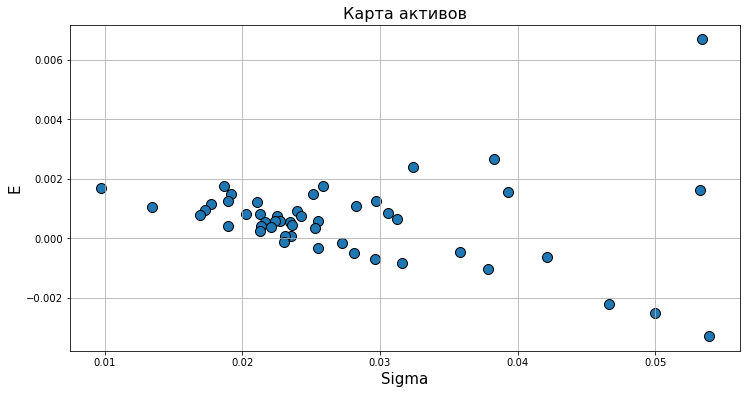

In [10]:
plot_mean_var_map(stats50, title='Карта активов')

In [11]:
log_returns

,Date,3IN,888,AAIF,AAL,AAS,ABD,ABDN,ABF,ACIC,...,WIZZ,WKP,WPP,WTAN,WTB,WWH,XAR,XPP,XPS,ZTF
0,2018-01-03 00:00:00+00:00,0.009500,0.006449,0.006889,-0.008057,0.009434,0.004149,-0.006840,0.020656,0.011209,...,-0.002165,0.007114,-0.025385,0.005561,0.001007,0.007905,0.006901,0.014389,0.002635,0.008762
1,2018-01-04 00:00:00+00:00,0.002360,0.000714,0.013637,0.014307,0.002345,0.010341,0.012700,0.001761,0.009509,...,-0.020523,-0.001013,0.012204,0.011030,0.006771,0.007843,0.002747,0.028171,-0.007926,-0.005467
2,2018-01-05 00:00:00+00:00,0.007050,0.007821,0.004505,-0.000997,-0.002345,0.004107,-0.000467,0.013976,0.014096,...,0.011818,0.026508,0.015423,0.003650,-0.001751,0.005842,0.031063,0.000000,0.002649,0.009820
3,2018-01-08 00:00:00+00:00,0.002342,-0.009249,0.011173,0.014611,0.000000,0.004090,0.010235,-0.010464,0.000000,...,0.002183,0.002957,-0.007870,0.000000,-0.009560,-0.007797,0.075532,0.013794,-0.002649,0.002169
4,2018-01-09 00:00:00+00:00,0.002333,0.015603,-0.004454,0.030269,-0.004706,0.004073,0.006689,-0.003513,0.000000,...,-0.004098,-0.005923,0.008243,0.005450,-0.003292,0.017459,-0.026235,-0.002744,0.002649,-0.017487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2018-12-20 00:00:00+00:00,0.015165,-0.037571,-0.002601,-0.028820,0.010050,-0.004556,0.003379,-0.003298,-0.005753,...,-0.004351,-0.013088,-0.028882,-0.021528,0.000896,-0.024541,-0.013245,0.018780,0.012579,0.020409
247,2018-12-21 00:00:00+00:00,0.003993,-0.028399,0.015504,0.028021,0.000000,-0.004577,0.013796,0.004238,-0.007722,...,0.002903,-0.019347,-0.002079,0.005168,-0.001792,-0.014599,0.000000,-0.009346,0.033797,0.093165
248,2018-12-24 00:00:00+00:00,-0.006091,-0.053121,-0.012903,-0.007104,-0.012073,0.009132,-0.016777,-0.022815,0.000000,...,-0.004357,-0.036051,-0.017493,-0.021887,0.013139,-0.012685,-0.052251,-0.018958,-0.033797,0.012195
249,2018-12-27 00:00:00+00:00,-0.006512,0.014158,-0.007823,-0.014479,0.022023,-0.013730,-0.003190,-0.018928,-0.005831,...,-0.009506,-0.000633,-0.023570,-0.001054,-0.010006,-0.010695,0.016466,0.028304,0.015504,0.003026


In [12]:
log_returns50 = log_returns[stats50.index]
log_returns50

,PNL,OCDO,PLUS,GFRD,NANO,HIK,ZTF,DEC,OXB,FUTR,...,IPF,PSON,CAPD,GNC,RCH,IWG,CPI,HNE,TTG,DSCV
0,0.000000,0.074836,0.221440,0.010035,0.011606,0.004951,0.008762,0.012626,-0.013882,0.000000,...,-0.023495,0.002176,0.0,-0.012579,0.032023,0.015957,-0.027948,0.002077,0.020112,0.010695
1,0.003665,0.034390,0.060838,0.005362,0.011472,0.000898,-0.005467,0.009988,0.068563,-0.018780,...,0.011567,-0.003265,0.0,0.009001,-0.018349,0.001929,0.039105,0.006205,0.004415,0.010582
2,0.001219,-0.001371,-0.015518,0.006852,0.053667,0.012926,0.009820,0.000000,0.071667,-0.016727,...,0.029559,0.001906,0.0,0.005808,0.012270,0.005764,0.021003,0.008214,0.004396,0.009168
3,-0.002439,-0.018934,-0.010480,-0.009912,-0.010870,-0.045298,0.002169,-0.006231,0.034898,0.014354,...,-0.009756,-0.010116,0.0,-0.030758,-0.007344,-0.000767,-0.036315,0.002043,0.006557,0.001303
4,0.000000,-0.010781,-0.005282,-0.004608,0.018051,-0.003714,-0.017487,0.006231,-0.012716,-0.004762,...,0.000000,0.014189,0.0,-0.000919,0.007344,0.006878,0.001224,-0.002043,-0.002181,0.012937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,-0.001268,-0.030009,-0.031480,0.021868,-0.002670,-0.047787,0.020409,-0.004454,-0.016727,-0.008247,...,-0.033799,-0.005559,0.0,0.069796,-0.020109,-0.012720,0.005962,-0.004963,0.020223,0.004686
247,0.000000,0.019153,0.001559,-0.009193,-0.027102,-0.053182,0.093165,0.026433,-0.028465,0.012346,...,-0.011871,-0.006669,0.0,0.005323,-0.004699,0.018537,-0.017063,-0.023151,-0.043997,-0.007823
248,-0.012771,-0.005995,0.013921,-0.000840,0.056089,0.018731,0.012195,-0.013129,-0.017195,0.000000,...,0.005179,0.001725,0.0,-0.004200,0.024808,-0.016570,-0.006533,0.000000,0.000000,-0.031918
249,0.000000,-0.020069,0.026527,-0.031585,-0.019673,-0.013343,0.003026,0.013129,0.000625,-0.031155,...,0.003094,-0.013886,0.0,-0.012422,-0.006145,-0.018349,-0.043537,-0.008180,0.001045,-0.016349


In [16]:
from scipy.optimize import minimize

def risk_porfolio(X, cov_matrix, n_observations=1, sqrt=True): # риск портфеля
    if sqrt:
        return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))
    else:
        return np.dot(np.dot(X, cov_matrix), X.T) / np.sqrt(n_observations)

def optimize_portfolio(risk_porfolio,
                       returns,
                       mean_returns, 
                       cov_matrix, 
                       bounds,
                       target_return=None):
    
    X = np.ones(returns.shape[1])
    X = X / X.sum()
    bounds = bounds * returns.shape[1]

    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    if target_return:
        constraints.append({'type': 'eq', 
                            'args': (mean_returns,), 
                            'fun': lambda X, mean_returns: portfolio_return - np.dot(X, mean_returns)})

    return minimize(risk_porfolio, X,
                    args=(cov_matrix, returns.shape[0]), 
                    method='SLSQP', # Метод наименьших квадратов
                    constraints=constraints,
                    bounds=bounds).x

In [70]:
psigmas = []
preturns = []
bounds = ((None, None),)
weights_50 = []
r_matrix, mean_vec, cov_matrix = log_returns50.values, log_returns50.mean().values, log_returns50.cov().values


X_min_risk = optimize_portfolio(risk_porfolio,
                                r_matrix,
                                mean_vec,
                                cov_matrix,
                                bounds)
min_risk = risk_porfolio(X_min_risk, cov_matrix)
min_risk_preturn = np.dot(X_min_risk, mean_vec)
target_range = np.linspace(min_risk_preturn, 0.05, 300)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           r_matrix,
                           mean_vec,
                           cov_matrix,
                           bounds,
                           target_return=portfolio_return)
    if not weights_50:
        weights_50.append(X)
    psigmas.append(risk_porfolio(X, cov_matrix))
    preturns.append(np.dot(X, mean_vec))

C:\Users\ciril\AppData\Local\Temp/ipykernel_996/2008321208.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for portfolio_return in tqdm_notebook(target_range):


In [84]:
def plot_weights_histogram(weights, data, title):
    '''
    Функция строит гистограмму, отображающую доли весов в портфеле
    '''
    plt.figure(figsize=(20,8))
    x_values = data.columns
    pairs_temp = sorted([(x_values[i], weights[i]) for i in range(len(x_values))], key = lambda x: x[1], reverse=True)
    x_values_new, weights_new = list(map(list, zip(*pairs_temp)))
    x = np.arange(len(weights_new))
    plt.xlabel('Акция')
    plt.ylabel('Вес')
    height = weights_new
    plt.bar(x, height=height)
    plt.xticks(x, x_values_new, rotation='50')
    plt.grid()
    plt.title(title, size=16)

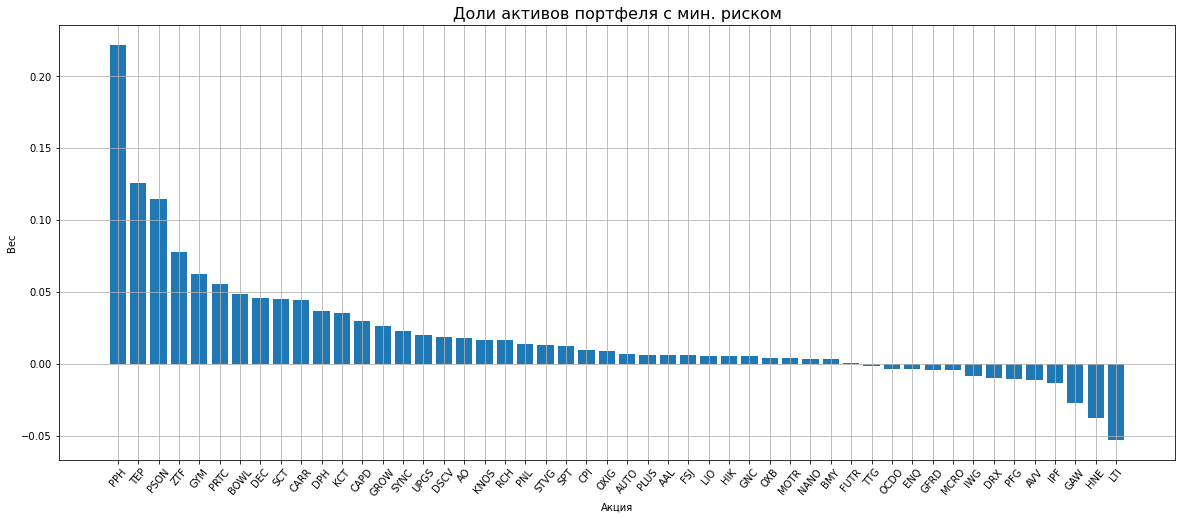

In [85]:
plot_weights_histogram(weights_50[0], log_returns50, title='Доли активов портфеля с мин. риском')

In [18]:
pairs = sorted([(psigmas[i], preturns[i]) for i in range(len(psigmas))], key = lambda x: x[0])
pairs = pairs[:100]
psigmas_new, preturns_new = list(map(list, zip(*pairs)))

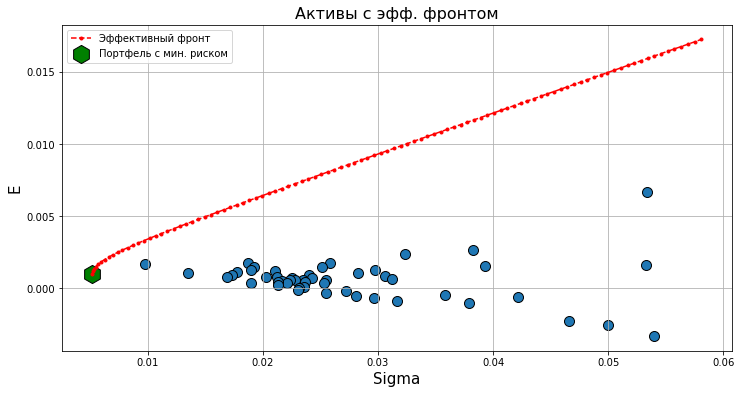

In [19]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk, 
            min_risk_preturn, 
            c='green',
            marker='h',
            s=330, 
            label='Портфель с мин. риском', 
            edgecolors='black',)
plt.plot(psigmas_new, preturns_new, 'r.--', label='Эффективный фронт')
plt.legend()
plt.show()

In [86]:
psigmas_ns = []
preturns_ns = []
bounds = ((0.0, 1.0),) 
weights_50_ns = []
r_matrix, mean_vec, cov_matrix = log_returns50.values, log_returns50.mean().values, cov_matrix


X_min_risk_ns = optimize_portfolio(risk_porfolio,
                                   r_matrix,
                                   mean_vec,
                                   cov_matrix,
                                   bounds)
min_risk_ns = risk_porfolio(X_min_risk_ns, cov_matrix)
min_risk_preturn_ns = np.dot(X_min_risk_ns, mean_vec)
target_range = np.linspace(min_risk_preturn_ns, 0.1, 500)


for portfolio_return in tqdm_notebook(target_range):
    X_ns = optimize_portfolio(risk_porfolio,
                                       r_matrix,
                                       mean_vec,
                                       cov_matrix,
                                       bounds, 
                                       target_return=portfolio_return)
    if not weights_50_ns:
        weights_50_ns.append(X_ns)
    psigmas_ns.append(risk_porfolio(X_ns, cov_matrix))
    preturns_ns.append(np.dot(X_ns, mean_vec))

C:\Users\ciril\AppData\Local\Temp/ipykernel_996/109438120.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for portfolio_return in tqdm_notebook(target_range):


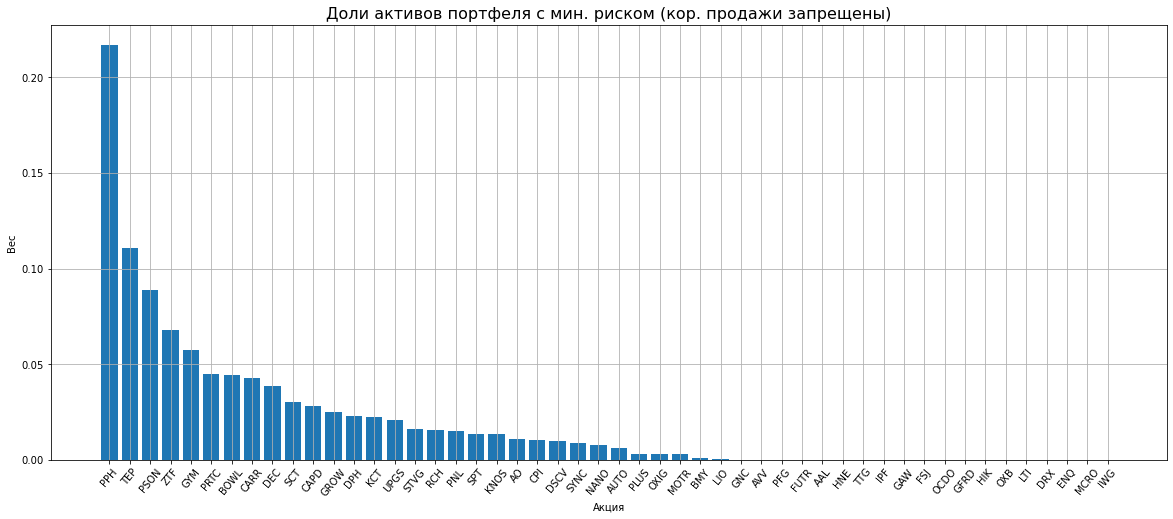

In [87]:
plot_weights_histogram(weights_50_ns[0], log_returns50, title='Доли активов портфеля с мин. риском (кор. продажи запрещены)')

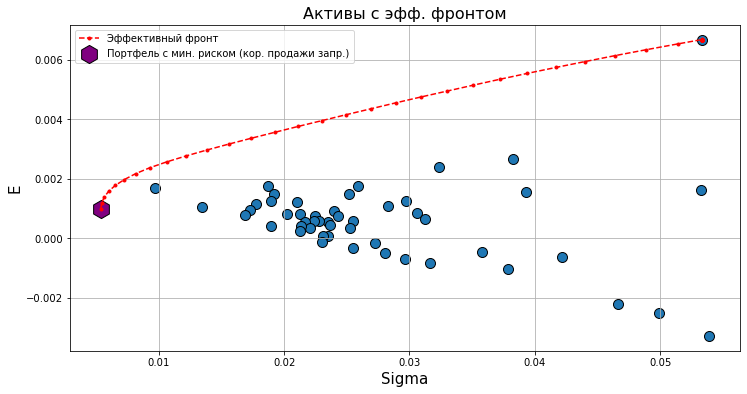

In [21]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='purple',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns, 'r.--', label='Эффективный фронт')
plt.legend()
plt.show()

### Портфель с равными долями

In [22]:
N = 50
part = 1/50
expected_return_knapsack = 0
for i in range(N):
  expected_return_knapsack += stats50['Expected returns'][i] * part

expected_return_knapsack

0.0005910994691808232

In [23]:
returns_eqw = []
for index, row in log_returns50.iterrows():
    returns_eqw.append(np.sum(row)/N)

deviation_knapsack = 0
tickers = stats50.index
for i in range(N-1):
  for j in range(1, N):
    deviation_knapsack += part**2 * np.cov(log_returns50[tickers[i]].astype('float32'), log_returns50[tickers[j]].astype('float32'))[0][1]

deviation_knapsack = math.sqrt(deviation_knapsack)
deviation_knapsack

0.007683063167962495

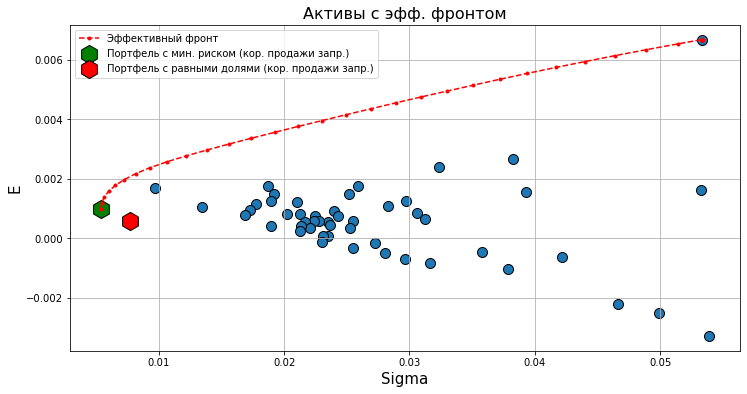

In [24]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='green',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)
plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns, 'r.--', label='Эффективный фронт')
plt.legend()
plt.show()

### Индекс рынка

In [25]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2018,12,31)
market_index = yf.download('^FTSE', start=start, end=end, progress=False)
market_index['Name'] = '^FTSE'
market_index
market_index_edited = market_index.drop(columns = ['Low', 'High', 'Open', 'Close', 'Volume'])
market_index_edited
#market_index_edited.set_index(['Date'])

index_data = (market_index.assign(idx=market_index.groupby('Name').cumcount())
                 .pivot_table(index='Date', columns='Name', 
                              values='Adj Close', aggfunc='sum'))
index_data

Name,^FTSE
Date,
2018-01-02,7648.100098
2018-01-03,7671.100098
2018-01-04,7695.899902
2018-01-05,7724.200195
2018-01-08,7696.500000
...,...
2018-12-20,6711.899902
2018-12-21,6721.200195
2018-12-24,6686.000000


In [26]:
index_log_return = np.log(index_data['^FTSE'] / index_data['^FTSE'].shift(1))
index_log_return.drop(["2018-01-02"], inplace=True)
index_mean = index_log_return.mean()
index_deviation = index_log_return.std()
print(index_mean,'\n\n', index_deviation)

-0.0005071232789132976 

 0.008037053981426309


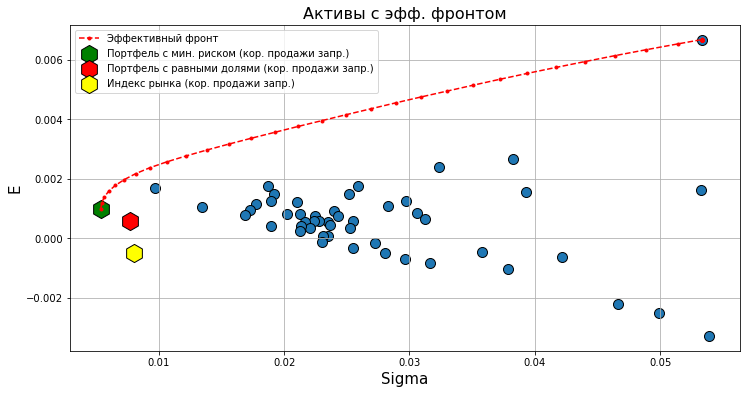

In [27]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='green',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(index_deviation, index_mean,
            c='yellow',
            marker='h',
            s=330,
            label='Индекс рынка (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns, 'r.--', label='Эффективный фронт')

plt.legend()
plt.show()

Итоговые результаты:

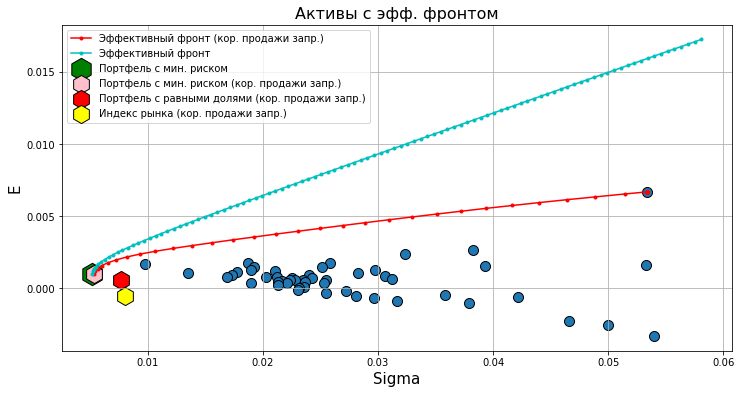

In [28]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk, 
            min_risk_preturn, 
            c='green',
            marker='h',
            s=500, 
            label='Портфель с мин. риском', 
            edgecolors='black',)

plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='pink',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(index_deviation, index_mean,
            c='yellow',
            marker='h',
            s=330,
            label='Индекс рынка (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_ns, preturns_ns,'r.-',  label='Эффективный фронт (кор. продажи запр.)')
plt.plot(psigmas_new, preturns_new,  'c.-', label='Эффективный фронт')
plt.legend()
plt.show()

## Задание 2. Portfolio selection problem.

2. Portfolio selection problem. Требуется построить «хорошие» инвестиционные портфели из 10 
активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов 
(из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора 
(50 акций)  и выбранного набора активов (10 акций) для двух случаев
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [29]:
stats10 = stats.sort_values(by=['Sharp Ratio'], ascending=False)
stats10 = stats10.head(10)
stats10

,Expected returns,Standard deviation,Sharp Ratio
PNL,0.006683,0.053384,0.078959
OCDO,0.002674,0.038284,0.005393
PLUS,0.002403,0.032382,-0.002014
GFRD,0.001622,0.053288,-0.015880
NANO,0.001548,0.039311,-0.023408
HIK,0.001741,0.025855,-0.028100
ZTF,0.001764,0.018678,-0.037664
DEC,0.001494,0.025162,-0.038713
OXB,0.001243,0.029698,-0.041251
FUTR,0.001091,0.028295,-0.048668


In [30]:
log_returns10 = log_returns50[stats10.index]
cov_matrix10 = log_returns10.cov().values

In [88]:
psigmas10 = []
preturns10 = []
bounds = ((None, None),)
weights_10 = []
r_matrix, mean_vec, cov_matrix = log_returns10.values, log_returns10.mean().values, cov_matrix10


X_min_risk_10 = optimize_portfolio(risk_porfolio,
                                r_matrix,
                                mean_vec,
                                cov_matrix,
                                bounds)
min_risk_10 = risk_porfolio(X_min_risk_10, cov_matrix)#, sqrt=True)
min_risk_preturn_10 = np.dot(X_min_risk_10, mean_vec)
target_range = np.linspace(min_risk_preturn_10, 0.05, 500)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           r_matrix,
                           mean_vec,
                           cov_matrix,
                           bounds,
                           target_return=portfolio_return)
    if not weights_10:
        weights_10.append(X)
    psigmas10.append(risk_porfolio(X, cov_matrix))#, sqrt=True))
    preturns10.append(np.dot(X, mean_vec))

C:\Users\ciril\AppData\Local\Temp/ipykernel_996/3388906428.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for portfolio_return in tqdm_notebook(target_range):


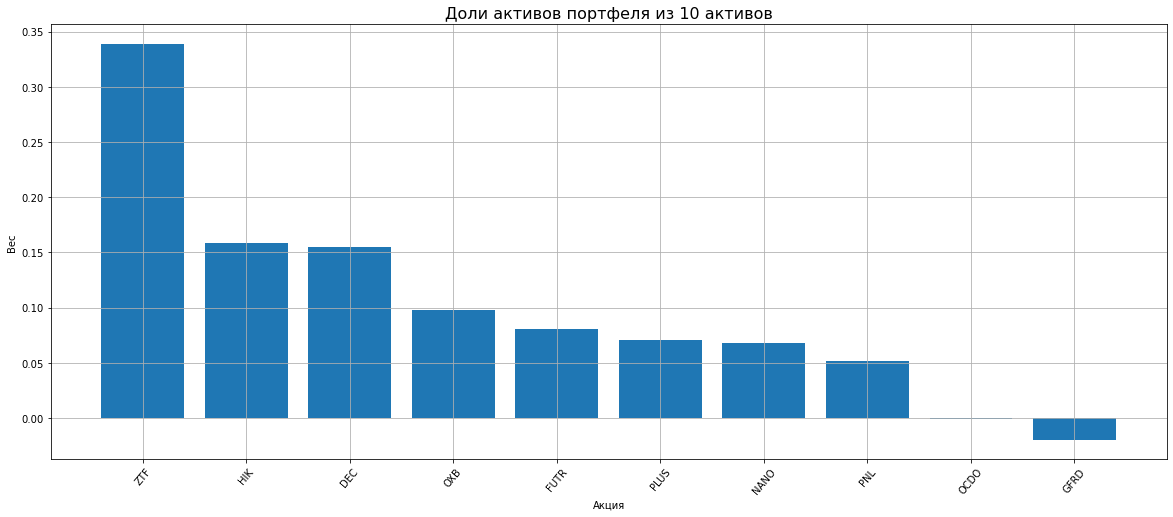

In [89]:
plot_weights_histogram(weights_10[0], log_returns10, title='Доли активов портфеля из 10 активов')

Интересно заметить, что мы практически не занимаемся короткими продажами при подобном портфеле.

Короткие продажи запрещены:

In [60]:
psigmas_ns_10 = []
preturns_ns_10 = []
bounds = ((0.0, 1.0),)
weights_10_ns = []
r_matrix, mean_vec, cov_matrix = log_returns10.values, log_returns10.mean().values, cov_matrix


X_min_risk_ns_10 = optimize_portfolio(risk_porfolio,
                                   r_matrix,
                                   mean_vec,
                                   cov_matrix,
                                   bounds)
min_risk_ns_10 = risk_porfolio(X_min_risk_ns_10, cov_matrix)
min_risk_preturn_ns_10 = np.dot(X_min_risk_ns_10, mean_vec)
target_range = np.linspace(min_risk_preturn_ns_10, 0.05, 500)


for portfolio_return in tqdm_notebook(target_range):
    X_ns = optimize_portfolio(risk_porfolio,
                                       r_matrix,
                                       mean_vec,
                                       cov_matrix,
                                       bounds, 
                                       target_return=portfolio_return)
    if not weights_10_ns:
        weights_10_ns.append(X_ns)
    psigmas_ns_10.append(risk_porfolio(X_ns, cov_matrix))
    preturns_ns_10.append(np.dot(X_ns, mean_vec))

C:\Users\ciril\AppData\Local\Temp/ipykernel_996/748153789.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for portfolio_return in tqdm_notebook(target_range):


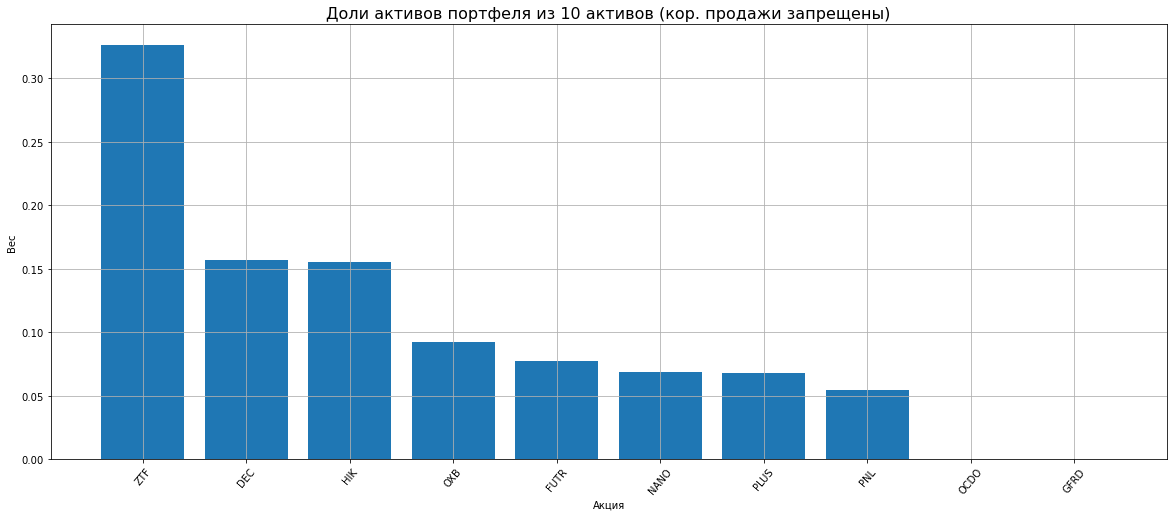

In [91]:
plot_weights_histogram(weights_10_ns[0], log_returns10, title='Доли активов портфеля из 10 активов (кор. продажи запрещены)')

In [33]:
# Режем масштаб
pairs10 = sorted([(psigmas10[i], preturns10[i]) for i in range(len(psigmas10))], key = lambda x: x[0])
pairs10 = pairs10[:70]
psigmas_new10, preturns_new10 = list(map(list, zip(*pairs10)))

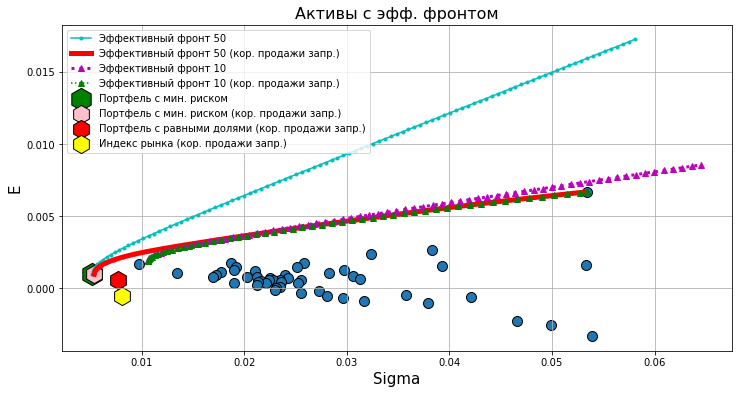

In [34]:
plot_mean_var_map(stats50,  title='Активы с эфф. фронтом')
plt.scatter(min_risk, 
            min_risk_preturn, 
            c='green',
            marker='h',
            s=500, 
            label='Портфель с мин. риском', 
            edgecolors='black',)

plt.scatter(min_risk_ns, 
            min_risk_preturn_ns, 
            c='pink',
            marker='h',
            s=330, 
            label='Портфель с мин. риском (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(deviation_knapsack, expected_return_knapsack,
            c='red',
            marker='h',
            s=330,
            label='Портфель с равными долями (кор. продажи запр.)', 
            edgecolors='black',)

plt.scatter(index_deviation, index_mean,
            c='yellow',
            marker='h',
            s=330,
            label='Индекс рынка (кор. продажи запр.)', 
            edgecolors='black',)
plt.plot(psigmas_new, preturns_new,  'c.-', label='Эффективный фронт 50')
plt.plot(psigmas_ns, preturns_ns,'r.-',  label='Эффективный фронт 50 (кор. продажи запр.)', linewidth=5.0)
plt.plot(psigmas_new10, preturns_new10,  '^m:', label='Эффективный фронт 10', linewidth=3.0)
plt.plot(psigmas_ns_10, preturns_ns_10,  '^g:', label='Эффективный фронт 10 (кор. продажи запр.)')
plt.legend()
plt.show()

## Задание 3. Risk aversion.

Оцените свое отношение к риску и постройте свой личный оптимальный портфель 
инвестиций из выбранных 50 активов.  Дайте характеристику портфеля по составу и долям активов. 
Оцените VaR доходностей портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [94]:
from scipy import stats

weights_personal_50 = []

def objective_function(X, returns, risk_level, cov_matrix):
    # risk_level is alpha
    return - np.dot(returns, X) + risk_level * risk_porfolio(X, cov_matrix)
    
def optimize_risk_aversion_portfolio(objective_function, returns, cov_matrix, risk_level, bounds, N):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    
    return minimize(objective_function, X,
                    args=(returns, risk_level, cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    
def risk_aversion_computing(params_, statsN, sse_components=False):
    min_risk, min_risk_preturn, losses = [], [], {}
    N = params_['data'].shape[1]
    E = statsN['Expected returns'].values
    r_matrix, mean_vec, cov_matrix = params_['data'].values, params_['data'].mean().values, params_['data'].cov().values
    X_min_risks = []
    bounds = ((-1, 1),) if params_['short'] else ((0, 1),)
    

    for risk_level in params_['risk_levels']:
        X_min_risk = optimize_risk_aversion_portfolio(objective_function, E, cov_matrix, 
                                                      risk_level, bounds, N)
        if not weights_personal_50:
            weights_personal_50.append(X_min_risk)
        min_risk.append(risk_porfolio(X_min_risk, cov_matrix))
        min_risk_preturn.append(np.dot(X_min_risk, E))
        losses[risk_level] = - np.dot(r_matrix,X_min_risk)
        X_min_risks.append(X_min_risk)
    return min_risk, min_risk_preturn, losses, X_min_risks

def plot_risk_aversion_method(params_, min_risk_, min_risk_preturn_, short=False):
    plot_mean_var_map(stats50, title='Карта активов')
    short_sales_word = 'разрешением коротких продаж с alpha = ' if short else 'запретом коротких продаж alpha = '

    for ind, risk_level in enumerate(params_['risk_levels']):
        plt.scatter(min_risk_[ind], min_risk_preturn_[ind],
                marker='*', s=300, edgecolors='black', label = 'Портфель с '+short_sales_word+str(risk_level))
    plt.legend()
    plt.show()

In [128]:
params_50 = {}
min_risk, min_risk_preturn = [], []
params_50['short'] = True
params_50['data'] = log_returns50
params_50['risk_levels'] = [0.3, 1, 2.5, 5] # к-т отвращения к риску
#params_50['risk_levels'] = np.linspace(1, 5, 5)
losses = {} # вычислим потери как минус лог. доходности

min_risk, min_risk_preturn, losses, X_mins_ = risk_aversion_computing(params_50, stats50, sse_components=True)

In [100]:
len(weights_personal_50)

1

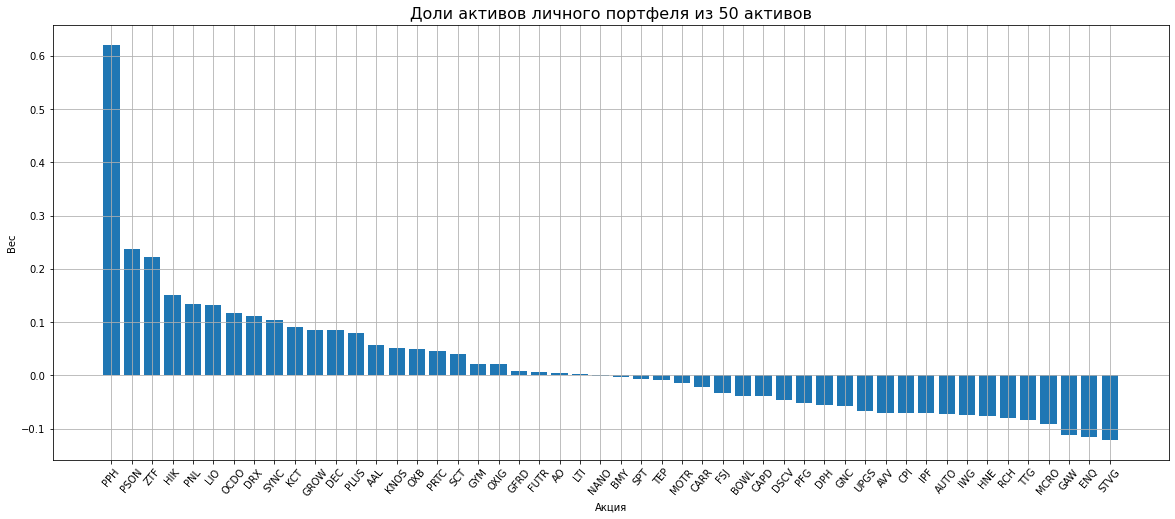

In [101]:
plot_weights_histogram(weights_personal_50[0], log_returns50, title='Доли активов личного портфеля из 50 активов')

In [ ]:
weights_personal_50 = []

if not weights_50:
    weights_50.append(X)

plot_weights_histogram(weights_50[0], log_returns50, title='Доли активов портфеля из 10 активов (кор. продажи запрещены)')

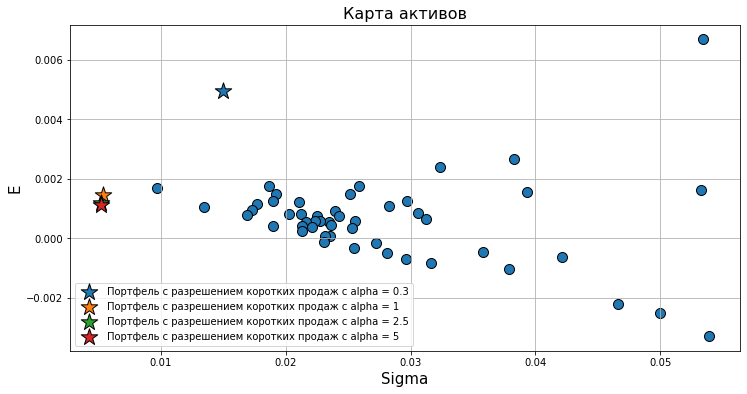

In [40]:
plot_risk_aversion_method(params_50, min_risk, min_risk_preturn, True)

In [136]:
from scipy.stats import norm

def VaR_info(risk_levels_, losses_):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for risk_level in risk_levels_:
        print('VaR характеристика для портфеля с уровнем отвращения к риску %s:' % risk_level)
        for clvl in confidence_lvl:
            loss = losses_[risk_level]
            loss = loss[np.isfinite(loss)]
            VaR[clvl] = np.quantile(loss, clvl)
            print(f' - Потери не превысят {np.round(VaR[clvl], 4)*100:.2f}% с {clvl} уверенностью.')
            
VaR_info(params_50['risk_levels'], losses)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 1.08% с 0.9 уверенностью.
 - Потери не превысят 1.68% с 0.95 уверенностью.
 - Потери не превысят 2.69% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 0.46% с 0.9 уверенностью.
 - Потери не превысят 0.61% с 0.95 уверенностью.
 - Потери не превысят 1.41% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 0.46% с 0.9 уверенностью.
 - Потери не превысят 0.65% с 0.95 уверенностью.
 - Потери не превысят 1.40% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 0.48% с 0.9 уверенностью.
 - Потери не превысят 0.66% с 0.95 уверенностью.
 - Потери не превысят 1.39% с 0.99 уверенностью.


Запрещаем короткие продажи:

In [131]:
params_50_no_short = params_50
params_50_no_short['short'] = False
losses_no_short = {} # вычислим потери как минус лог. доходности
min_risk_no_short, min_risk_preturn_no_short = [], []
weights_personal_50 = []
min_risk_no_short, min_risk_preturn_no_short, losses_no_short, X_mins_50_ns = risk_aversion_computing(params_50_no_short, stats50,
                                                                                        sse_components=True)

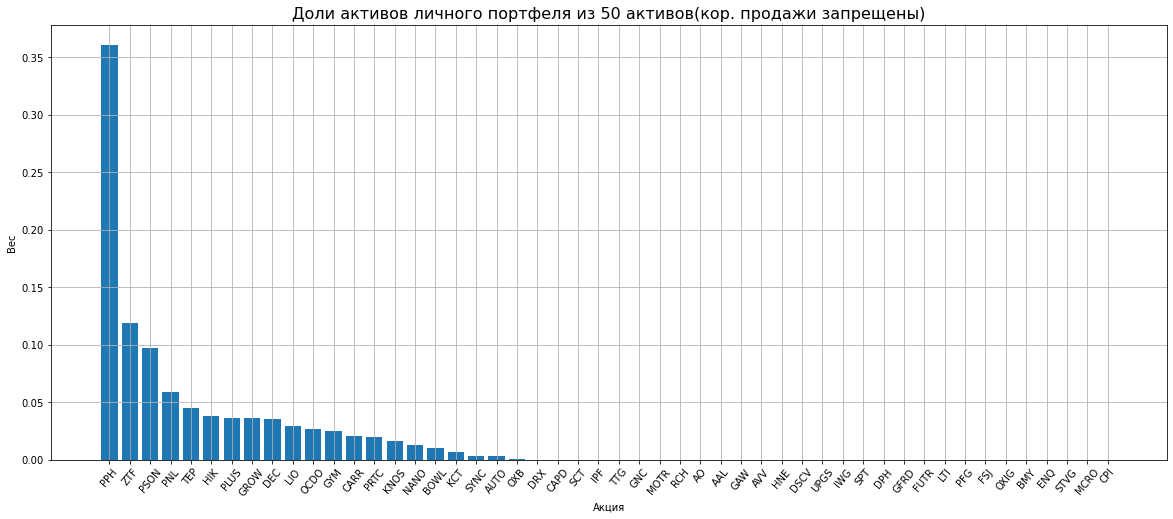

In [132]:
plot_weights_histogram(weights_personal_50[0], log_returns50, title='Доли активов личного портфеля из 50 активов(кор. продажи запрещены)')

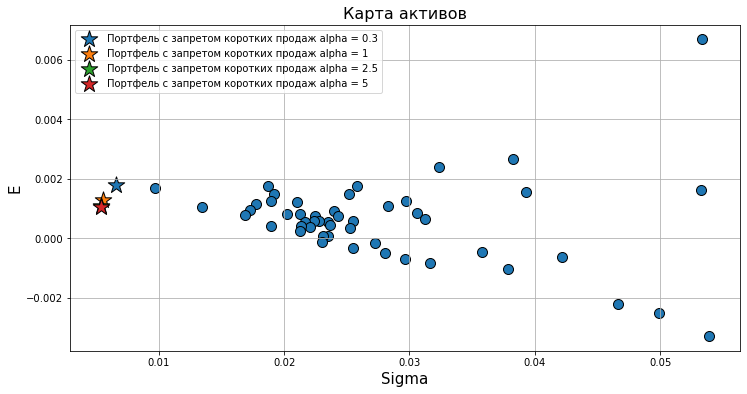

In [44]:
plot_risk_aversion_method(params_50_no_short, min_risk_no_short, min_risk_preturn_no_short, short=False)

In [137]:
VaR_info(params_50_no_short['risk_levels'], losses_no_short)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 0.47% с 0.9 уверенностью.
 - Потери не превысят 0.63% с 0.95 уверенностью.
 - Потери не превысят 1.49% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 0.42% с 0.9 уверенностью.
 - Потери не превысят 0.64% с 0.95 уверенностью.
 - Потери не превысят 1.40% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 0.46% с 0.9 уверенностью.
 - Потери не превысят 0.63% с 0.95 уверенностью.
 - Потери не превысят 1.32% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 0.47% с 0.9 уверенностью.
 - Потери не превысят 0.64% с 0.95 уверенностью.
 - Потери не превысят 1.29% с 0.99 уверенностью.


## Задание 4. Risk aversion and Portfolio selection.
Используя выбранное  в п.3 отношение к риску постройте  
оптимальный портфель из 10 активов (вместо 50, см. п.2). Дайте характеристику этого портфеля по 
составу активов и долям инвестиций. Сравните с портфелем п.3. Оцените VaR доходностей 
портфеля. Рассмотрите два случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.
Можно ли ваш портфель из 10 активов улучшить, оставаясь в рамках 10 активов из выбранных ранее 
50 активов?

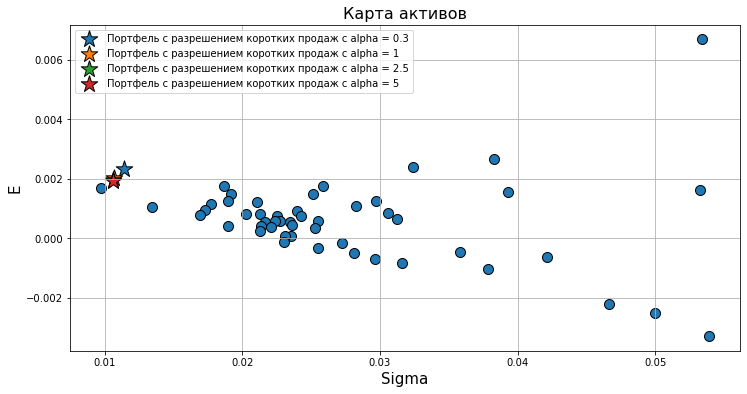

In [118]:
params_10 = params_50
params_10['short'] = True
params_10['data'] = log_returns10
losses, min_risk_10, min_risk_preturn = {}, [], []
weights_personal_50 = [] # tyt tipo 10
min_risk_10, min_risk_preturn, losses_10, X_mins_10 = risk_aversion_computing(params_10, stats10)
plot_risk_aversion_method(params_10, min_risk_10, min_risk_preturn, short=True)

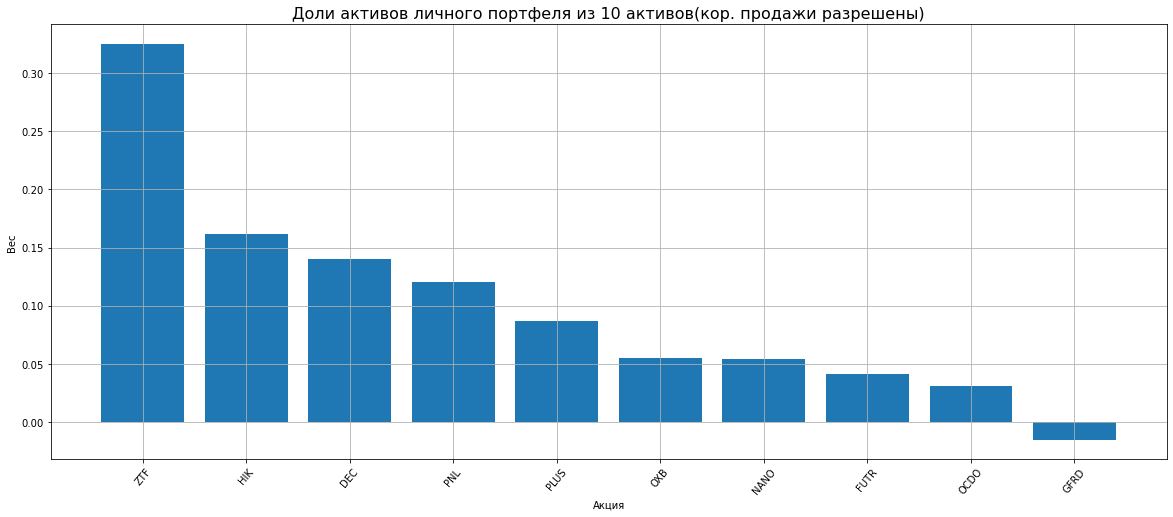

In [120]:
plot_weights_histogram(weights_personal_50[0], log_returns10, title='Доли активов личного портфеля из 10 активов(кор. продажи разрешены)')

In [138]:
VaR_info(params_10['risk_levels'], losses_10)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 0.94% с 0.9 уверенностью.
 - Потери не превысят 1.41% с 0.95 уверенностью.
 - Потери не превысят 2.37% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 1.01% с 0.9 уверенностью.
 - Потери не превысят 1.48% с 0.95 уверенностью.
 - Потери не превысят 2.55% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 1.00% с 0.9 уверенностью.
 - Потери не превысят 1.51% с 0.95 уверенностью.
 - Потери не превысят 2.58% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 1.00% с 0.9 уверенностью.
 - Потери не превысят 1.53% с 0.95 уверенностью.
 - Потери не превысят 2.59% с 0.99 уверенностью.


Не шортим:

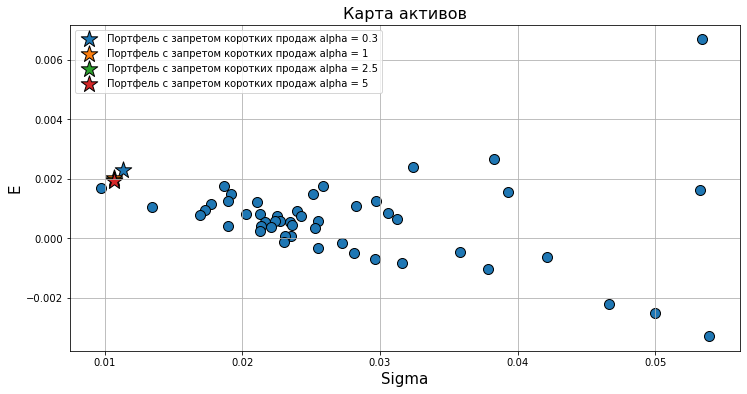

In [124]:
params_10_no_short = params_10
params_10_no_short['short'] = False
losses_ns, min_risk_ns, min_risk_preturn_ns = {}, [], []
weights_personal_50 = [] # tyt tipo 10
min_risk_ns, min_risk_preturn_ns, losses_ns, X_mins_10_ns = risk_aversion_computing(params_10_no_short, stats10)
plot_risk_aversion_method(params_10_no_short, min_risk_ns, min_risk_preturn_ns, short=False)

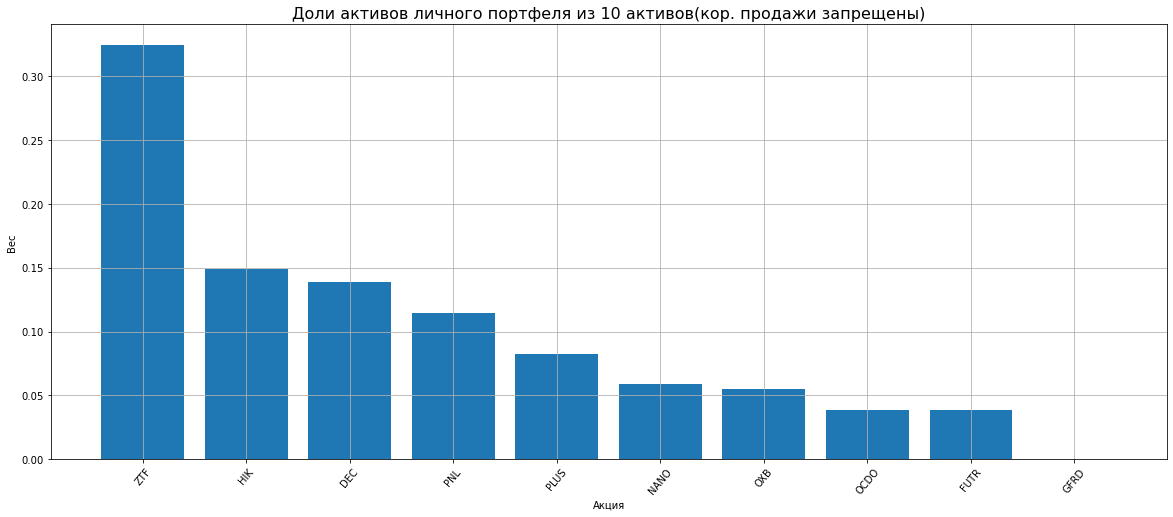

In [125]:
plot_weights_histogram(weights_personal_50[0], log_returns10, title='Доли активов личного портфеля из 10 активов(кор. продажи запрещены)')

In [139]:
VaR_info(params_10_no_short['risk_levels'], losses_ns)

VaR характеристика для портфеля с уровнем отвращения к риску 0.3:
 - Потери не превысят 0.95% с 0.9 уверенностью.
 - Потери не превысят 1.44% с 0.95 уверенностью.
 - Потери не превысят 2.32% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 1:
 - Потери не превысят 1.03% с 0.9 уверенностью.
 - Потери не превысят 1.48% с 0.95 уверенностью.
 - Потери не превысят 2.49% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 2.5:
 - Потери не превысят 1.00% с 0.9 уверенностью.
 - Потери не превысят 1.52% с 0.95 уверенностью.
 - Потери не превысят 2.51% с 0.99 уверенностью.
VaR характеристика для портфеля с уровнем отвращения к риску 5:
 - Потери не превысят 0.99% с 0.9 уверенностью.
 - Потери не превысят 1.54% с 0.95 уверенностью.
 - Потери не превысят 2.53% с 0.99 уверенностью.


## Задание 5. Markowitz-Tobin model.
Рассмотрите набор активов, отобранных в п.2 (10 активов).  Выберете  
безрисковый актив (можно виртуальный). Постройте рыночный (оптимальный)  портфель. Сделайте 
анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два 
случая: 
- короткие продажи разрешены, 
- короткие продажи запрещены.

In [52]:
def objective_function(x, cov_matix, mean_vector, risk_free_mean):
    f = float(-(x.dot(mean_vector) - risk_free_mean) / np.sqrt(np.dot(np.dot(x, cov_matrix), x.T)))
    return f


def optimal_portfolio_sharp_ratio(profits, risk_free_mean, N, cov_matrix,returns,bounds):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    minimize = optimize.minimize(objective_function, X,
                    args=(cov_matrix, returns, risk_free_mean,), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    return minimize

def optimal_portfolio_computing(data,risk_free_asset, allow_short = False):
    results = {}
    risk_free_mean = risk_free_asset
    N = log_returns10.shape[1]
    r_matrix, cov_matrix = log_returns10.values, log_returns10.cov().values
    E = stats10['Expected returns'].values
    bounds = ((-1, 1),) if allow_short else ((0, 1),)
    optim_portfolio_weights =  optimal_portfolio_sharp_ratio(log_returns10, risk_free_mean,N,cov_matrix,E, bounds)
    results['optim_weights'] = optim_portfolio_weights
    results['best_sharp_sigma'] = risk_porfolio(optim_portfolio_weights, cov_matrix)
    results['best_sharp_return'] = np.dot(optim_portfolio_weights, E)
    results['losses'] = -np.dot(r_matrix, optim_portfolio_weights)
    return results

def plot_optimal_sharp_ratio_portfolio_method(data, best_sharp_sigma, best_sharp_return, short=False):
    plot_mean_var_map(data, title='Карта активов')
    short_sales_word = 'разрешением' if short else 'запретом'
    plt.scatter(best_sharp_sigma, best_sharp_return,
                marker='*', s=300, 
                label='Рыночный (оптимальный) портфель с ' + short_sales_word + ' коротких продаж', 
                edgecolors='red')
    plt.legend()
    plt.show()

In [53]:
short_results = optimal_portfolio_computing(log_returns10, Ef, allow_short=True)

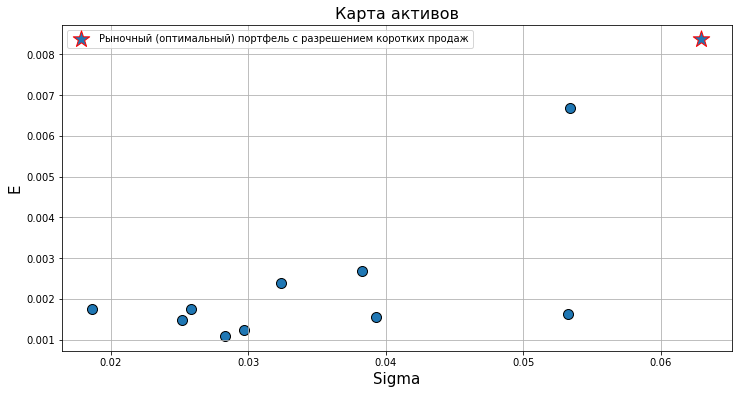

In [54]:
plot_optimal_sharp_ratio_portfolio_method(stats10, 
                                          short_results['best_sharp_sigma'],
                                          short_results['best_sharp_return'], 
                                          short=True)

Короткие запрещены:

In [55]:
long_results = optimal_portfolio_computing(log_returns10, Ef, allow_short=False)

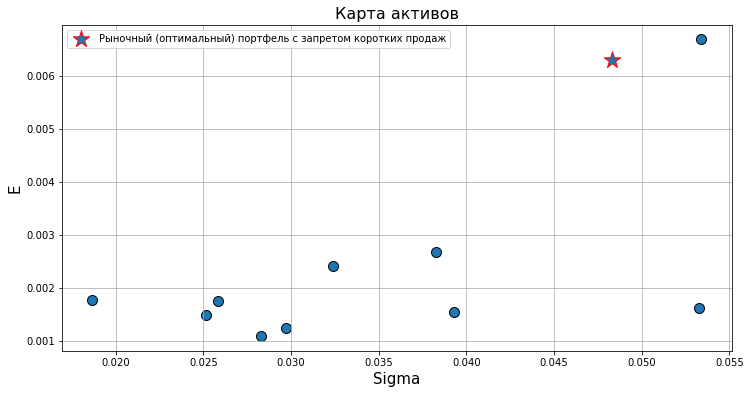

In [56]:
plot_optimal_sharp_ratio_portfolio_method(stats10, 
                                          long_results['best_sharp_sigma'],
                                          long_results['best_sharp_return'], 
                                          short=False)

In [144]:
def VaR_info(losses):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for clvl in confidence_lvl:
        loss = losses[np.isfinite(losses)]
        VaR[clvl] = np.quantile(loss, clvl)
        print(f' - Потери не превысят {np.round(VaR[clvl], 4)*100:.2f}% с {clvl} уверенностью.')

In [145]:
print('Короткие продажи разрешены')
VaR_info(short_results['losses'])

Короткие продажи разрешены
 - Потери не превысят 3.69% с 0.9 уверенностью.
 - Потери не превысят 4.73% с 0.95 уверенностью.
 - Потери не превысят 7.37% с 0.99 уверенностью.


In [146]:
print('Короткие продажи запрещены')
VaR_info(long_results['losses'])

Короткие продажи запрещены
 - Потери не превысят 0.58% с 0.9 уверенностью.
 - Потери не превысят 0.83% с 0.95 уверенностью.
 - Потери не превысят 1.15% с 0.99 уверенностью.


# 🤪